In [1]:
# from adnmtf import NMF, NTF
import pandas as pd
import numpy as np
from IPython.display import clear_output
import time
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import matplotlib.image as image
import sys
import networkx as nx
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn.preprocessing import quantile_transform

from adnmtf import NMF
import adilsm.adilsm as ilsm

DATA_PATH = r'C:\Users\paul_\OneDrive\Pro\Galderma\Vevey\NEMO Phase 3\AD\EASI\results\ISM\ISM lab\csv'
RESULTS_PATH = r'C:\Users\paul_\OneDrive\Pro\Galderma\Vevey\NEMO Phase 3\AD\EASI\results\ISM\ISM lab\csv'

adilsm version=0.0.11


Data prep

In [6]:
Xs = []
df_blood = pd.read_csv(DATA_PATH + r'\blood.csv', na_values=' ', index_col='SUBJID')
Xs.append(df_blood.values.astype(np.float_))
list_columns = df_blood.columns.to_list()

df_hemato = pd.read_csv(DATA_PATH + r'\hematology.csv', na_values=' ', index_col='SUBJID')
Xs.append(df_hemato.values.astype(np.float_))
list_columns += df_hemato.columns.to_list()

# for i in range(len(Xs)):
#     quantile_transform(Xs[i], n_quantiles=Xs[0].shape[0], copy=False)

score_pref = ['Blood chemistry', 'Hematology']

n_scores = 2
n_items = [Xs[0].shape[1], Xs[1].shape[1]]

ISM workflow

In [12]:
condition_number = np.zeros(11)
relative_error = np.zeros(11)
for i_screeplot in range(3,4):
    n_embedding, n_themes = [i_screeplot,i_screeplot]

    ilsm_result = ilsm.ism(Xs, n_embedding, n_themes, norm_columns=True, update_h_ism=True,
                    max_iter_integrate = 20, max_iter_mult=200, fast_mult_rules=True, sparsity_coeff=.8)
    hv = ilsm_result['HV']
    hv_sparse = ilsm_result['HV_SPARSE']
    hhii_updated = ilsm_result['HHII']
    w4_ism = ilsm_result['W']
    h4_ism = ilsm_result['H']
    q4_ism = ilsm_result['Q']
    Xs_emb = ilsm_result['EMBEDDING']
    Xs_norm = ilsm_result['NORMED_VIEWS']

    h4_updated = hv[0].copy()
    h4_updated_sparse = hv_sparse[0].copy()
    for h in hv[1:]:
        h4_updated = np.vstack((h4_updated, h))
    for h in hv_sparse[1:]:
        h4_updated_sparse = np.vstack((h4_updated_sparse, h))

    m0 = Xs_norm[0].copy()
    for x in Xs_norm[1:]:
        m0 = np.hstack((m0, x))

    condition_number[i_screeplot] = np.linalg.cond(h4_updated)
    # print('condition number('+str(n_embedding)+', '+str(n_themes)+') = ', np.round(condition_number[i_screeplot], 2))
    relative_error[i_screeplot] = np.linalg.norm(m0 -  w4_ism @ h4_updated.T) / np.linalg.norm(m0)
    # print('relative error: ',round(relative_error[i_screeplot], 2))

error ism before straightening:  0.19
error ism after straightening:  0.19


In [10]:
# Plot screeplots

Screeplots

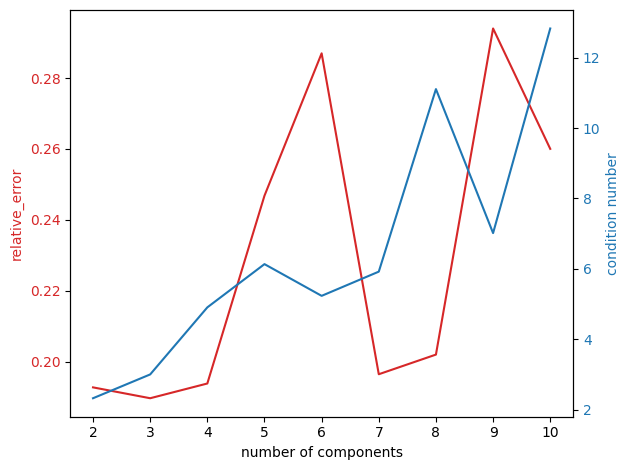

In [11]:
#  Create a figure and axes
fig, ax1 = plt.subplots()

# Plot the first dataset (exp) on the left y-axis
color1 = 'tab:red'
ax1.set_xlabel('number of components')
ax1.set_ylabel('relative_error', color=color1)
ax1.plot(range(2, len(relative_error)), relative_error[2:], color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis (right y-axis) that shares the same x-axis
ax2 = ax1.twinx()

# Plot the second dataset (sin) on the right y-axis
color2 = 'tab:blue'
ax2.set_ylabel('condition number', color=color2)
ax2.plot(range(2, len(condition_number)), condition_number[2:], color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Adjust layout and display the plot
fig.tight_layout()
plt.show()

Save ISM results

In [13]:
# Save
df_h4_updated_sparse = ilsm.format_loadings(h4_updated_sparse, list_columns)
df_h4_updated_sparse.to_csv(RESULTS_PATH + r'\h4_updated_sparse.csv', sep=',', na_rep='.', index=True)

df_h4_updated = ilsm.format_loadings(h4_updated_sparse, list_columns)
df_h4_updated.to_csv(RESULTS_PATH + r'\h4_updated.csv', sep=',', na_rep='.', index=True)

df_q4_ism = pd.DataFrame(q4_ism)
df_q4_ism.columns = ['theme_' + str(i) for i in range(1, n_themes + 1)]
df_q4_ism.insert(loc=0, column='score', value=score_pref)
df_q4_ism.to_csv(RESULTS_PATH + r'\q4_ism.csv', sep=',', na_rep='.', index=True)

cluster = np.argmax(w4_ism, axis=1)+1
# cluster = np.argmax(normalize(w4_ism, norm='max', axis=0), axis=1)+1

calinski_harabasz_score = metrics.calinski_harabasz_score(w4_ism, cluster)
print(f'calinski_harabasz_score: {calinski_harabasz_score}')
# silhouette_score = metrics.silhouette_score(w4_ism, cluster, metric='euclidean')
# print(f'Silhouette Score: {silhouette_score}')

df_w4_ism = pd.DataFrame(np.column_stack((w4_ism, cluster)))
df_w4_ism.columns = ['theme_' + str(i) for i in range(1, n_themes + 1)] + ['nmf_cluster']

def calculate_value(row):
    for i in range(1, n_themes+1):
        if row.iloc[n_themes] == i:
            return row.iloc[i-1]

# Apply the function to each row
df_w4_ism['nmf_cluster_loading'] = df_w4_ism.apply(lambda row: calculate_value(row), axis=1)

for k in range(1,n_themes+1):
    df_w4_ism['pred_'+str(k)] = df_w4_ism['theme_'+str(k)] / df_w4_ism[['theme_' +str(i) for i in range(1,n_themes+1) if i != k]].max(axis=1)

df_w4_ism.columns = ['theme_' + str(i) for i in range(1, n_themes + 1)] + ['nmf_cluster', 'nmf_cluster_loading'] +  ['pred_' + str(i) for i in range(1, n_themes + 1)]

# df_w4_ism.insert(0, 'TRTP', df['TRTP'].to_list())
# df_w4_ism.insert(0, 'ASEX', df['ASEX'].to_list())
# df_w4_ism.insert(0, 'AGEGR1', df['AGEGR1'].to_list())
df_w4_ism.insert(loc=0, column='SUBJID', value=(df_blood.index.to_list()))
df_w4_ism.set_index('SUBJID', inplace=True)
df_w4_ism.to_csv(RESULTS_PATH + r'\w4_ism.csv', sep=',', na_rep='.',index=True)

# df_easy_by_time = pd.read_csv(DATA_PATH + r'\adeff_easi_no_dtype_no_doubles.csv', na_values=' ', index_col='USUBJID')
# merged_df = pd.merge(df_w4_ism, df_easy_by_time, on='USUBJID')
# merged_df.to_csv(RESULTS_PATH + r'\w4_ism_adeff_easi.csv', sep=',', na_rep='.',index=True)

# print('condition number(w4_ism) = '  + str(np.linalg.cond(w4_ism)))

# # Save the tensor
# df_tensor_score = pd.DataFrame(data=tensor_score)
# df_tensor_score.columns = [score_pref[j] + ':theme_' + str(i) for j in range(len(score_pref)) for i in range(1, int(tensor_score.shape[1]/n_scores) + 1)]
# df_tensor_score.insert(loc=0, column='wise_id', value=(df.index.to_list()))
# df_tensor_score.set_index('wise_id', inplace=True)
# df_tensor_score.to_csv(RESULTS_PATH + r'\tensor_score.csv', sep=',', na_rep='.', index=True)

calinski_harabasz_score: 424.3498487338912


Figures

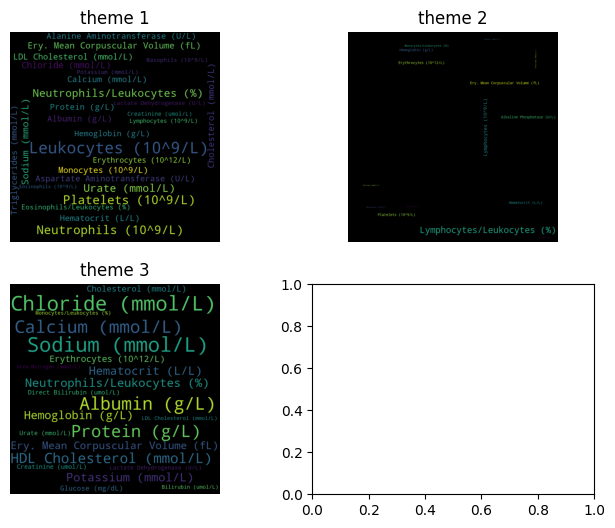

In [14]:
# Plot word clouds of the survey items
ncols = 2
nrows = int(np.ceil(n_themes/ncols))

irow = 0
icol = -1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 6))

for i in range(1,n_themes+1):
    sub_df_h4_updated=df_h4_updated_sparse[df_h4_updated_sparse.columns[[0,i]]].set_index('label').T.to_dict('list')
    for k in sub_df_h4_updated:
        sub_df_h4_updated[k] = sub_df_h4_updated[k][0]

#    wc = WordCloud(width=800, height=800, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df)
    # wc = WordCloud(width=800, height=800, min_font_size=4, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df_h4)
    wc = WordCloud(width=800, height=800, min_font_size=4, relative_scaling=1).generate_from_frequencies(sub_df_h4_updated)

    icol = icol+1
    title = 'theme ' + str(i)
    axes[irow, icol].imshow(wc)
    axes[irow, icol].axis('off')
    axes[irow, icol].set_title(title)
    # axes[icol].imshow(wc)
    # axes[icol].axis('off')
    # axes[icol].set_title(title)
    if icol==ncols-1:
        icol = -1
        irow+=1
 
fig_name=RESULTS_PATH + r'\word_clouds_items.png'
plt.savefig(fig_name, dpi=300)
plt.show()

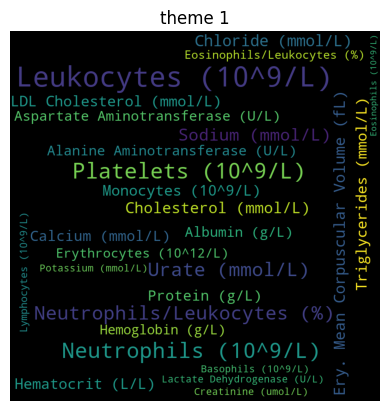

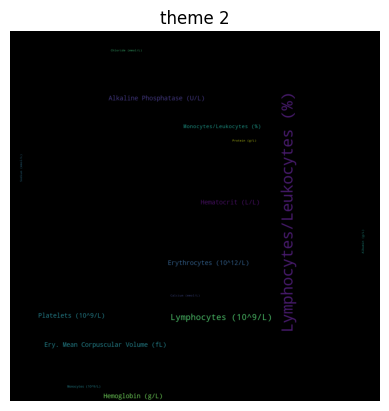

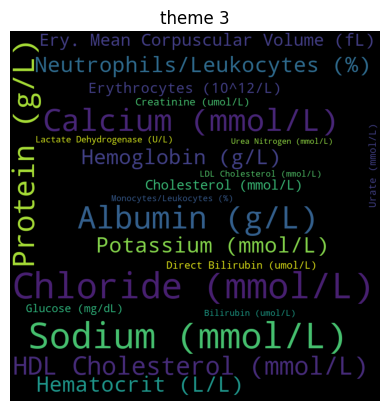

In [15]:
# Plot individual word clouds of the survey items

for i in range(1,n_themes+1):
    sub_df_h4_updated=df_h4_updated_sparse[df_h4_updated_sparse.columns[[0,i]]].set_index('label').T.to_dict('list')
    for k in sub_df_h4_updated:
        sub_df_h4_updated[k] = sub_df_h4_updated[k][0]

#    wc = WordCloud(width=800, height=800, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df)
    # wc = WordCloud(width=800, height=800, min_font_size=4, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df_h4)
    wc = WordCloud(width=800, height=800, min_font_size=4, relative_scaling=1).generate_from_frequencies(sub_df_h4_updated)

    title = 'theme ' + str(i)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    fig_name=RESULTS_PATH + r'\word_clouds_items_theme '+str(i)+'.png'
    plt.savefig(fig_name, dpi=300)
    plt.show()

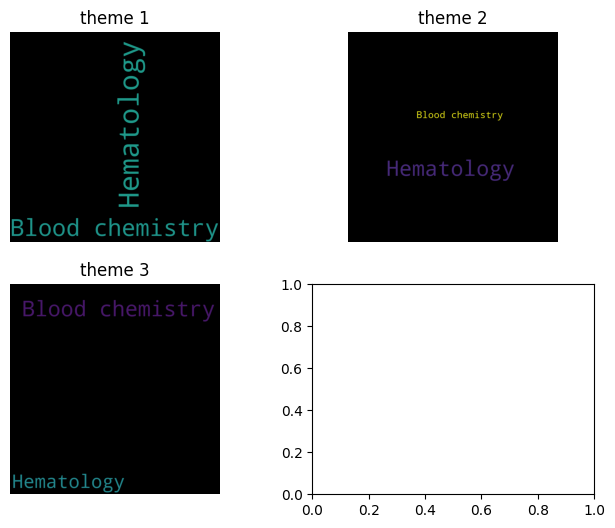

In [16]:
# Plot word clouds of the surveys
ncols = 2
nrows = int(np.ceil(n_themes/ncols))

irow = 0
icol = -1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 6))

for i in range(1,n_themes+1):
    sub_df_q4_ism=df_q4_ism[df_q4_ism.columns[[0,i]]].set_index('score').T.to_dict('list')
    for k in sub_df_q4_ism:
        sub_df_q4_ism[k] = sub_df_q4_ism[k][0]

#    wc = WordCloud(width=800, height=800, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df)
    # wc = WordCloud(width=800, height=800, min_font_size=4, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df_h4)
    wc = WordCloud(width=800, height=800, min_font_size=4, relative_scaling=1).generate_from_frequencies(sub_df_q4_ism)

    icol = icol+1
    title = 'theme ' + str(i)
    axes[irow, icol].imshow(wc)
    axes[irow, icol].axis('off')
    axes[irow, icol].set_title(title)
    if icol==ncols-1:
        icol = -1
        irow+=1
 
fig_name=RESULTS_PATH + r'\word_clouds_surveys.png'
plt.savefig(fig_name, dpi=300)
plt.show()

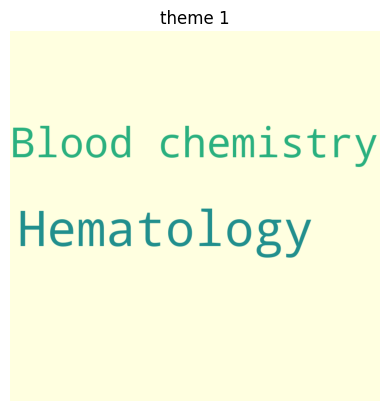

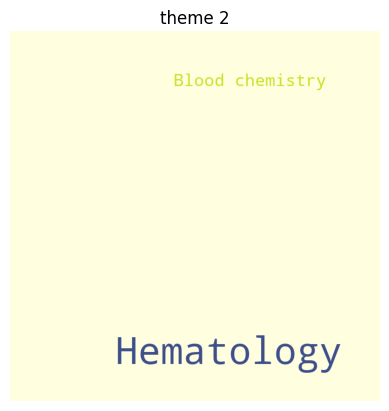

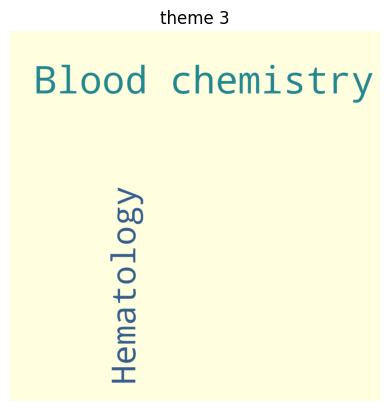

In [17]:
# Plot individual word clouds of the surveys

for i in range(1,n_themes+1):
    sub_df_q4_ism=df_q4_ism[df_q4_ism.columns[[0,i]]].set_index('score').T.to_dict('list')
    for k in sub_df_q4_ism:
        sub_df_q4_ism[k] = sub_df_q4_ism[k][0]

#    wc = WordCloud(width=800, height=800, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df)
    # wc = WordCloud(width=800, height=800, min_font_size=4, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df_h4)
    wc = WordCloud(width=800, height=800, min_font_size=4, background_color='lightyellow', relative_scaling=1).generate_from_frequencies(sub_df_q4_ism)

    title = 'theme ' + str(i)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    fig_name=RESULTS_PATH + r'\word_clouds_surveys_theme '+str(i)+'.png'
    plt.savefig(fig_name, dpi=300)
    plt.show()

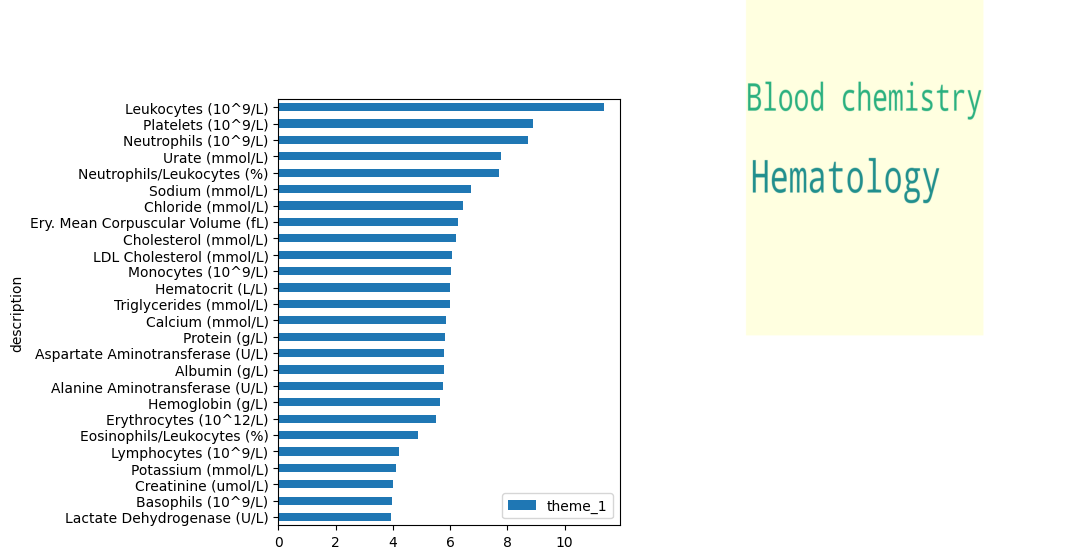

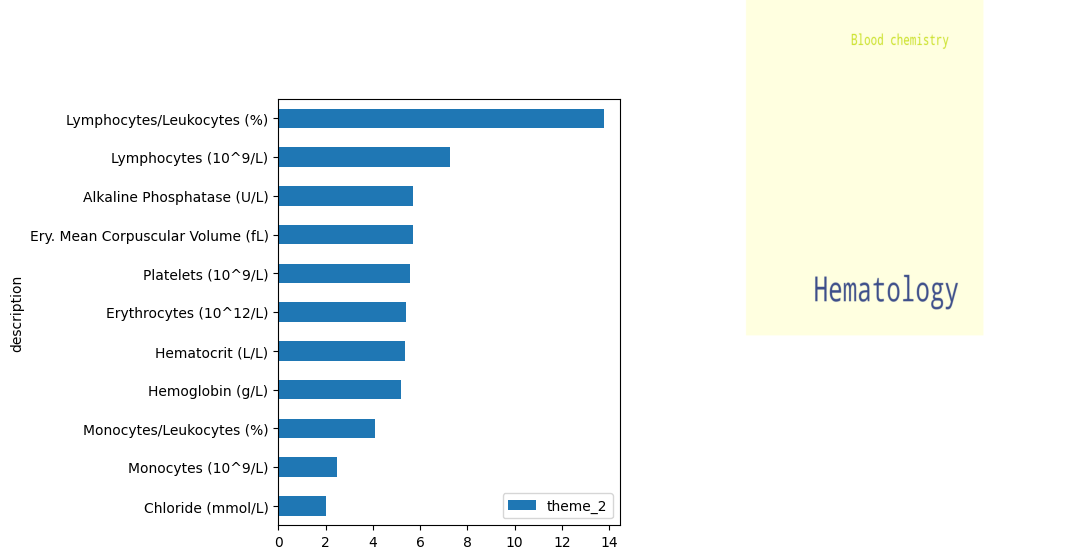

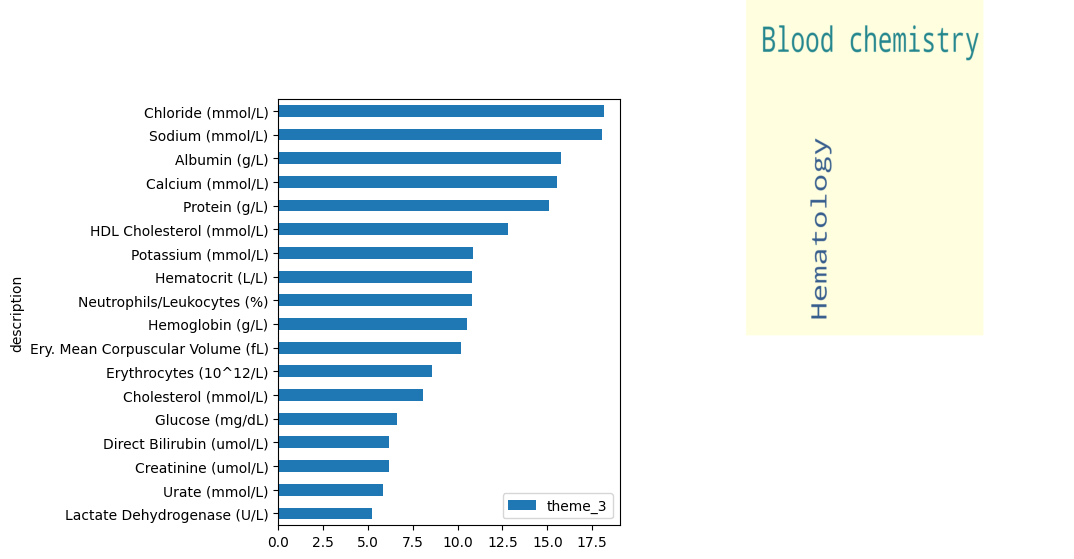

In [18]:
# Plot horizontal bar charts of the themes
for i in range(0,n_themes):
# for i in range(0,1):
    # plot the horizontal bar chart with ordered values
    df_temp = df_h4_updated_sparse[['description','theme_'+str(i+1)]].sort_values(by='theme_'+str(i+1), ascending=False).iloc[0:hhii_updated[i],:]
    df_temp.plot.barh(x='description', y='theme_'+str(i+1))
    fig_name=RESULTS_PATH + r'\theme_' + str(i+1) + '.png'
    plt.tight_layout()
    ax = plt.gca() # get the current axes object
    ax.invert_yaxis() # invert the y-axis
    # fig = plt.gcf()

    # Insert word cloud
    img = image.imread(RESULTS_PATH + r'\word_clouds_surveys_theme '+str(i+1)+'.png')
    # create a new axis for the image
    # ax = plt.gca()
    newax = ax.inset_axes([1.1, 0.25, 1.2, 1.2]) # adjust the position and size of the image
    newax.imshow(img)
    newax.axis("off") # turn off the axis

    plt.savefig(fig_name, dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
# Plot individual word clouds of the survey items

for i in range(1,n_themes+1):
    sub_df_h4_updated=df_h4_updated[df_h4_updated.columns[[0,i]]].set_index('label').T.to_dict('list')
    for k in sub_df_h4_updated:
        sub_df_h4_updated[k] = sub_df_h4_updated[k][0]

#    wc = WordCloud(width=800, height=800, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df)
    # wc = WordCloud(width=800, height=800, min_font_size=4, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df_h4)
    wc = WordCloud(width=800, height=800, min_font_size=4, relative_scaling=1).generate_from_frequencies(sub_df_h4_updated)

    title = 'theme ' + str(i)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    fig_name=RESULTS_PATH + r'\word_clouds_items_theme '+str(i)+'.png'
    plt.savefig(fig_name, dpi=300)
    plt.show()

In [ ]:
# Plot horizontal bar charts of q4
for i in range(0,n_themes):
    # plot the horizontal bar chart with ordered values
    # df_temp = df_q4[['score','theme_'+str(i+1)]].sort_values(by='theme_'+str(i+1), ascending=False)
    df_temp = df_q4_ism[['score','theme_'+str(i+1)]]
    df_temp.plot.barh(x='score', y='theme_'+str(i+1))
    fig_name=RESULTS_PATH + r'\score_' + str(i+1) + '.png'
    plt.tight_layout()
    ax = plt.gca() # get the current axes object
    ax.invert_yaxis() # invert the y-axis
    # fig = plt.gcf()
    plt.savefig(fig_name, dpi=300)
    plt.show()
